<a href="https://colab.research.google.com/github/karencfisher/DS-Unit-1-Sprint-2-Statistics/blob/master/module3/LS_DS_123_Introduction_to_Bayesian_Inference_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lambda School Data Science Module 123

## Introduction to Bayesian Inference




In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from scipy.stats import bayes_mvs, t

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Assignment - Code it up!

We used pure math to apply Bayes Theorem to drug tests. Now write Python code to reproduce the results! This is purposefully open ended - you'll have to think about how you should represent probabilities and events. You can and should look things up.

Specific goals/targets:

### 1) Write a function 

`def prob_drunk_given_positive(prob_drunk_prior, false_positive_rate, true_positive_rate):` 

You should only truly need these two values in order to apply Bayes Theorem. In this example, imagine that individuals are taking a breathalyzer test with an 8% false positive rate, a 100% true positive rate, and that our prior belief about drunk driving in the population is 1/1000. 
 - What is the probability that a person is drunk after one positive breathalyzer test?
 - What is the probability that a person is drunk after two positive breathalyzer tests?
 - How many positive breathalyzer tests are needed in order to have a probability that's greater than 95% that a person is drunk beyond the legal limit?



In [0]:
def bayes_prob(prior, true_positive, false_positive):
  '''
  Calculate Baysian probability given test result
  '''

  marginal = true_positive * prior + (false_positive * (1 - prior))
  prob = (true_positive * prior) / marginal
  return prob


def iterative_prob(prior, true_positive, false_positive, threshold):
  '''
  Iteratively calculate baysian probability until specified threshold,
  and display results
  '''

  probabilities = []
  new_prior = prior
  iteration = 0
  p = 0
  while p < threshold:
    p = bayes_prob(new_prior, true_positive, false_positive)
    probabilities.append(p)
    iteration += 1
    new_prior = p
    print('Iteration: %i Probability: %f' % (iteration, p))

  print('\n')
  plt.plot(range(1, iteration + 1), probabilities, '-o')
  plt.xlabel('Iteration')
  plt.ylabel('Probability')
  plt.show()



Iteration: 1 Probability: 0.012358
Iteration: 2 Probability: 0.135252
Iteration: 3 Probability: 0.661600
Iteration: 4 Probability: 0.960690




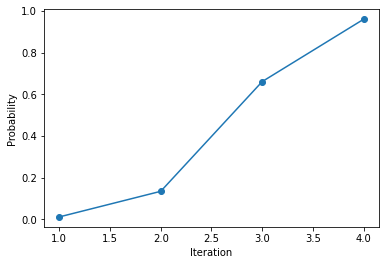

In [3]:
true_positive = 1
false_positive = .08
expected_prob = 1 / 1000
iterative_prob(expected_prob, true_positive, false_positive, .95)

### 2) Explore `scipy.stats.bayes_mvs`  
Read its documentation, and experiment with it on data you've tested in other ways earlier this week.
 - Create a visualization comparing the results of a Bayesian approach to a traditional/frequentist approach. (with a large sample size they should look close to identical, however, take this opportunity to practice visualizing condfidence intervals in general. The following are some potential ways that you could visualize confidence intervals on your graph:
  - [Matplotlib Error Bars](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.pyplot.errorbar.html)
  - [Seaborn barplot with error bars](https://seaborn.pydata.org/generated/seaborn.barplot.html)
  - [Vertical ines to show bounds of confidence interval](https://www.simplypsychology.org/confidence-interval.jpg)
  - [Confidence Intervals on Box Plots](https://matplotlib.org/3.1.1/api/_as_gen/matplotlib.axes.Axes.boxplot.html)





**Sale prices from the Ames Housing Dataset**

In [4]:
# Get just prices, and HouseStyle for use further on
url = 'https://raw.githubusercontent.com/ryanleeallred/datasets/master/Ames%20Housing%20Data/train.csv'
Ames_df = pd. read_csv(url)
Ames_df = Ames_df[['HouseStyle', 'SalePrice']]
Ames_df.head()

,HouseStyle,SalePrice
0,2Story,208500
1,1Story,181500
2,2Story,223500
3,2Story,140000
4,2Story,250000


**Frequentist confidence interval**


In [0]:
def confidence_interval(sample, cl):
  '''
  Calculate mean, confidence interval

  sample: data to process, such as Pandas series
  cl: confidence limit (e.g. 0.95)

  return: list of mean, lower and upper limits for CI
  '''
  
  n = len(sample)
  dof = n - 1
  sample_mean = sum(sample) / n
  sample_std = np.sqrt(sum((sample - sample_mean)**2) / (n-1))
  sample_se = sample_std / np.sqrt(n)
  t_stat = t.ppf((1 + cl) / 2, dof)
  sample_me = t_stat * sample_se
  upper_conf = sample_mean + sample_me
  lower_conf = sample_mean - sample_me

  return [sample_mean, lower_conf, upper_conf]


In [6]:
freq_ci = confidence_interval(Ames_df['SalePrice'], .95)
freq_ci

[180921.19589041095, 176842.84104108496, 184999.55073973694]

**Bayesian confidence interval**

In [7]:
bayes_stats = bayes_mvs(Ames_df['SalePrice'])
bayes_ci = bayes_stats[0]
bayes_ci

Mean(statistic=180921.19589041095, minmax=(177502.54333066105, 184339.84845016085))

**Graphic Comparison**  
Density plot of data, with CI as span

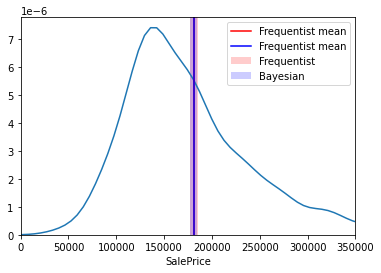

In [8]:
sns.distplot(Ames_df['SalePrice'], hist=False, rug=False)
plt.xlim(0, 350000)
plt.axvspan(freq_ci[1], freq_ci[2], facecolor='r', alpha=0.2, label='Frequentist')
plt.axvline(freq_ci[0], color='red', label="Frequentist mean")
plt.axvspan(bayes_ci[1][0], bayes_ci[1][1], facecolor='b', alpha=0.2, label='Bayesian')
plt.axvline(bayes_ci[0], color='blue', label="Frequentist mean")
plt.legend();

Zoom in even more to see difference in confidence intervals.

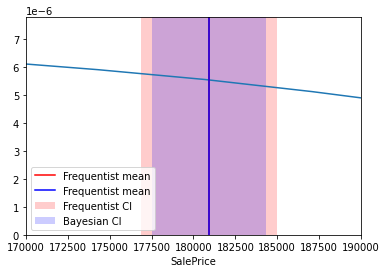

In [9]:
sns.distplot(Ames_df['SalePrice'], hist=False, rug=False)
plt.xlim(170000, 190000)
plt.axvspan(freq_ci[1], freq_ci[2], facecolor='r', alpha=0.2, label='Frequentist CI')
plt.axvline(freq_ci[0], color='red', label="Frequentist mean")
plt.axvspan(bayes_ci[1][0], bayes_ci[1][1], facecolor='b', alpha=0.2, label='Bayesian CI')
plt.axvline(bayes_ci[0], color='blue', label="Frequentist mean")
plt.legend();

### 3) In your own words, summarize the difference between Bayesian and Frequentist statistics

If you're unsure where to start, check out [this blog post of Bayes theorem with Python](https://dataconomy.com/2015/02/introduction-to-bayes-theorem-with-python/).

*Frequentist statistics focus on objective probability. To seek to avoid bias, samples are used to rule out the null hypothesis to support (or not) a given hypothesis. It allows the data to drive the process, which is obective, even if the ultimate parameters remain unknown. Bayesian statistics, on the other hand, begin with a subjective probability, belief, intuition, or and initial hypothesis, in it's more poular sense of the word (the "prior"). It then seeks to refine that hypothesis given the observed data (the "posterior"). The latter more embraces uncertainty, and belief.*

*The Scipy.stats.bayes_mvs function returns a somewhat narrower confidence interval than a frequentist calculation, with the same 95% confidence level.* 



## Resources

- [Worked example of Bayes rule calculation](https://en.wikipedia.org/wiki/Bayes'_theorem#Examples) (helpful as it fully breaks out the denominator)
- [Source code for mvsdist in scipy](https://github.com/scipy/scipy/blob/90534919e139d2a81c24bf08341734ff41a3db12/scipy/stats/morestats.py#L139)

## Stretch Goals:

- Go back and study the content from Modules 1 & 2 to make sure that you're really comfortable with them.
- Apply a Bayesian technique to a problem you previously worked (in an assignment or project work) on from a frequentist (standard) perspective
- Check out [PyMC3](https://docs.pymc.io/) (note this goes beyond hypothesis tests into modeling) - read the guides and work through some examples
- Take PyMC3 further - see if you can build something with it!

# What is the probability P(A|B) of a house being two story, given it's high price?
Using Bayes theorem.




In [10]:
# Refine the Ames to look four just one and two story cases in HouseStyle
Ames_df = Ames_df[Ames_df['HouseStyle'].isin(['2Story', '1Story'])]

# And categorize into two proce ranges, low or high depending on below or above
# median price
price_bins = [Ames_df['SalePrice'].min(), Ames_df['SalePrice'].median(), Ames_df['SalePrice'].max()]
price_labels = ['low', 'high']
Ames_df['priceRange'] = pd.cut(Ames_df['SalePrice'], bins=price_bins, labels=price_labels)
Ames_df.dropna(inplace=True)

Ames_df.sample(5)

,HouseStyle,SalePrice,priceRange
1109,1Story,280000,high
132,1Story,150750,low
206,1Story,143900,low
107,1Story,115000,low
858,1Story,152000,low


In [11]:
# Crosstab with mormalization will give us a matrix of proportions of price ranges
# by number of floors.
house_price = pd.crosstab(Ames_df['HouseStyle'], Ames_df['priceRange'], margins=True, normalize=True)
house_price

priceRange,low,high,All
HouseStyle,,,
1Story,0.369231,0.250427,0.619658
2Story,0.130769,0.249573,0.380342
All,0.500000,0.500000,1.000000


**Given the price for a house being high, what is the probability it has two stories?**

P(A) = probability being two story = 0.380342

P(B|A) = probability high price given it's two story = 0.249573

p(B) = probability any house is high price = .5


In [0]:
def bayes_prob(prior, conditional, marginal):
  prob = conditional * prior / marginal
  return prob

In [13]:
p_a = house_price.iloc[1]['All']
p_b = house_price.iloc[2]['high']
p_b_a = house_price.iloc[1]['high']
p_a_b = bayes_prob(p_b_a, p_a, p_b)
print('Probability house is two stories = %.3f%%' % (p_a_b * 100) )

Probability house is two stories = 18.985%


**And given it's low price, what is the probability that it is single story?**

P(A) = probability being single story = 0.619658

P(B|A) = probability low price given it's one story = 0.369231

p(B) = probability any house is low price = .5

In [14]:
p2_a = house_price.iloc[0]['All']
p2_b = house_price.iloc[2]['low']
p2_b_a = house_price.iloc[0]['low']
p2_a_b = bayes_prob(p2_b_a, p2_a, p2_b)
print('Probability house is single story = %.3f%%' % (p2_a_b * 100) )

Probability house is single story = 45.759%


# Frequentist (or non-bayes) approach to same (or similar) question?
Or, exploring the probability a house has two stories given a high price, calculated without Bayes.




In [0]:
def p_conf_interval(sample, probability, cl):
  '''
  Given a probability, calculate confidence interval around it.
  '''
  
  se = np.sqrt(probability * (1- probability) / len(sample))
  t_stat = t.ppf((1 + .95) / 2, len(sample) - 1)
  lower_conf = probability - t_stat * se
  upper_conf = probability + t_stat * se
  return(probability, lower_conf, upper_conf)


First, in order to use mean to calculate probabilities, recode HouseStyle and priceRange into integer forms, 1 or 0.

In [16]:
Ames_df['priceRangeBinary'] = Ames_df['priceRange'].map({'high': 1, 'low': 0}, )
Ames_df['priceRangeBinary'] = Ames_df['priceRangeBinary'].astype('int')
Ames_df['StoriesBinary'] = Ames_df['HouseStyle'].map({'2Story': 1, '1Story': 0}, )
Ames_df['StoriesBinary'] = Ames_df['StoriesBinary'].astype('int')
Ames_df.sample(3)

,HouseStyle,SalePrice,priceRange,priceRangeBinary,StoriesBinary
1294,1Story,115000,low,0,0
470,1Story,212000,high,1,0
505,2Story,124500,low,0,1


Calculate the probability of houses which are of high price and 2 of stories, and calculate confidence interval around it? What will that tell us?

Since the two probabilities of each are independent:

\begin{equation*}
P(A \cap B) = P(A) \times P(B)
\end{equation*}

In [17]:
prob_a_and_b = Ames_df['StoriesBinary'].mean() * Ames_df['priceRangeBinary'].mean()
a_and_b_stats = p_conf_interval(Ames_df['StoriesBinary'], prob_a_and_b, .95)
a_and_b_stats

(0.19017094017094016, 0.16766102791319862, 0.2126808524286817)

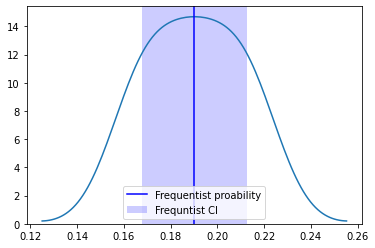

In [18]:
sns.distplot(a_and_b_stats, hist=False, rug=False)
plt.axvspan(a_and_b_stats[1], a_and_b_stats[2], facecolor='b', alpha=0.2, label='Frequntist CI')
plt.axvline(a_and_b_stats[0], color='blue', label="Frequentist proability")
plt.legend();

Compare the results with the previous bayesian calculation for P(A|B). Nearly identical.

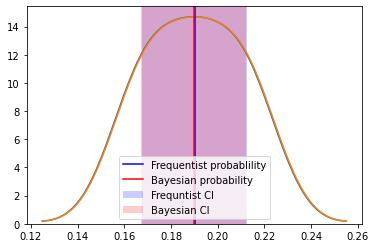

In [19]:
# Calculate a confidence interval around the probability calculated earlier, using
# Bayes
bayes_stats = p_conf_interval(Ames_df['StoriesBinary'], p_a_b, .95)

#plot them together
sns.distplot(bayes_stats, hist=False, rug=False)
sns.distplot(a_and_b_stats, hist=False, rug=False)
plt.axvspan(a_and_b_stats[1], a_and_b_stats[2], facecolor='b', alpha=0.2, label='Frequntist CI')
plt.axvline(a_and_b_stats[0], color='blue', label="Frequentist probablility")
plt.axvspan(bayes_stats[1], bayes_stats[2], facecolor='r', alpha=0.2, label='Bayesian CI')
plt.axvline(bayes_stats[0], color='red', label="Bayesian probability")
plt.legend();

But then, I think, classically perhaps, P(A | B) is different from just P(A and B):

\begin{equation*}
P(A | B) \neq P(A \cap B)
\end{equation*}

But

\begin{equation*}
P(A | B) = \frac{P(A \cap B)}{P(B)}
\end{equation*}

Right? But calculating P(A|B) this way, we end up different results. The non-Bayes probabilty ends up being twice the Bayes probability. The Bayes C.I. ends up being again narrower somewhat. Is it in the end here comparing apples and oranges?



In [20]:
# probability of a house being high price
prob_b = Ames_df['priceRangeBinary'].mean()
b_stats = p_conf_interval(Ames_df['priceRangeBinary'], prob_b, .95)
b_stats

(0.5, 0.4713202704738816, 0.5286797295261184)

In [21]:
# And calculate P(2 Story|high price)
prob_a_given_b = a_and_b_stats[0] / b_stats[0]
stats = p_conf_interval(Ames_df['StoriesBinary'], prob_a_given_b, .95)
stats

(0.3803418803418803, 0.3524955356973393, 0.4081882249864213)

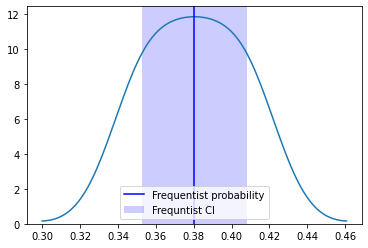

In [22]:

sns.distplot(stats, hist=False, rug=False)
plt.axvspan(stats[1], stats[2], facecolor='b', alpha=0.2, label='Frequntist CI')
plt.axvline(stats[0], color='blue', label="Frequentist probability")
plt.legend();

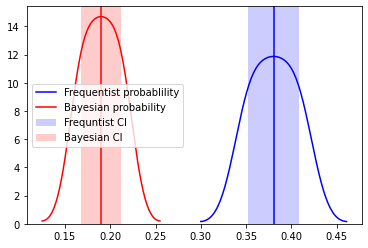

In [23]:
# Plot them together now
sns.distplot(bayes_stats, hist=False, rug=False, color='red')
sns.distplot(stats, hist=False, rug=False, color='blue')
plt.axvspan(stats[1], stats[2], facecolor='b', alpha=0.2, label='Frequntist CI')
plt.axvline(stats[0], color='blue', label="Frequentist probablility")
plt.axvspan(bayes_stats[1], bayes_stats[2], facecolor='r', alpha=0.2, label='Bayesian CI')
plt.axvline(bayes_stats[0], color='red', label="Bayesian probability")
plt.legend();

**Maybe this just winds up being that I have a lot to still learn!**